In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py, pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [3]:
trajl = 41
wellsInfo = 'Awells'
conditions = ['A2'] # LIGANDS or CONDITIONS
tmSet = ['EGF1']
n_conditions = len(tmSet) # Total number of Ligand Conditions
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
# Indices for the ligands 
inds_tmSet = [i for i in range(n_conditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(n_conditions)]
modelList = [None]*(nfovs*(n_conditions))
modelList_conditions = np.zeros(nfovs*(n_conditions)).astype(int)

In [5]:
i = 0
icond = 0
for cond in conditions:
    modelList_conditions[i] = icond
    modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fovs[0])+dateSet[imagingSet[icond]]
    #print("Models: ",modelList[i])
    i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
    inds_imagingSet_models[i] = imagingSet[icond]
    icond = icond + 1

In [10]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [11]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [12]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [13]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xf = Xf[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [14]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell 35855, 2 tracks, 31300 left
tracked cell

In [15]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

Single-cell Trajectories Over The Cell Features

In [16]:
Xf_traj = np.zeros((0, n_features*trajl + n_COMfeatures*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

building trajectory data for model 0...


In [17]:
inds_conditions = [None]*n_conditions
for imf in range(n_conditions):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for im in indmodels:
        indtm = np.where(indtreatment_traj == im)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory snippet indices: Add up all FOVs
    #print(inds_conditions[imf])

In [18]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [19]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_1.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [20]:
cc_values_last_frames = []
for cond in range(n_conditions):
    indstm = inds_conditions[cond] # Condition Specific Indices
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    ################## Identify the "FULL" trajectory index and locate snippets within it ##################
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
        indc_ccvals_traj = possible_indices[0][0]
        #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
        cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
        #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
        cc_values_last_frames.append(cc_vals)
cc_values_last_frames = np.array(cc_values_last_frames)

In [21]:
X = Xf_traj
y = cc_values_last_frames

In [22]:
pca = PCA(n_components = 0.95)
pca.fit(X) 
Xpca = pca.transform(X)
print(f"Number of Features afer PCA: {Xpca.shape[1]}")

Number of Features afer PCA: 178


Split data into training and testing to evaluate performance

In [23]:
X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.2, random_state=42)

In [24]:
data = y
variance = np.var(data)
std_dev = np.std(data)
print(f"Variance of the data: {variance}")
print(f"Standard deviation of the data: {std_dev}")

Variance of the data: 0.059469900056613276
Standard deviation of the data: 0.24386451167936116


In [26]:
threshold = 2.5 * std_dev
mean_data = np.mean(data)
# Identify outliers: Data beyond "mean +/- 2*standard_deviation"
outliers = data[(data < mean_data - threshold) | (data > mean_data + threshold)] 
non_outliers = data[(data >= mean_data - threshold) & (data <= mean_data + threshold)]
print(f"Outliers: {outliers}, Length of Outliars: {len(outliers)}")
print(f"Non-outliers: {non_outliers}, Length of non-outliars: {len(non_outliers)}")

Outliers: [-0.0454792  -0.01339921 -0.02996746 -0.02550145 -0.06179683 -0.15184884
 -0.29954489 -0.10761754 -0.08122208 -0.14067389 -0.17617326 -0.14803883
 -0.1671993  -0.03675874 -0.01703297 -0.26386195 -0.2050052  -0.01946207
 -0.00607028 -0.03194076 -0.00973431  0.00574344 -0.04060136 -0.002814
 -0.02852579 -0.02852579], Length of Outliars: 26
Non-outliers: [0.3779671  0.34464673 0.32360622 ... 0.32859432 0.38018489 0.4266384 ], Length of non-outliars: 6475


In [27]:
non_outlier_condition = (data >= mean_data - threshold) & (data <= mean_data + threshold)
non_outlier_indices = np.where(non_outlier_condition)[0]

In [28]:
cc_vals_non_outliers = y[non_outlier_indices]
X_non_outliers = Xpca[non_outlier_indices]

In [29]:
# Split Non-Outlier Data Into Training & Test Sets 
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_non_outliers, 
                                                                cc_vals_non_outliers,
                                                                test_size = 0.2,
                                                                random_state = 42)

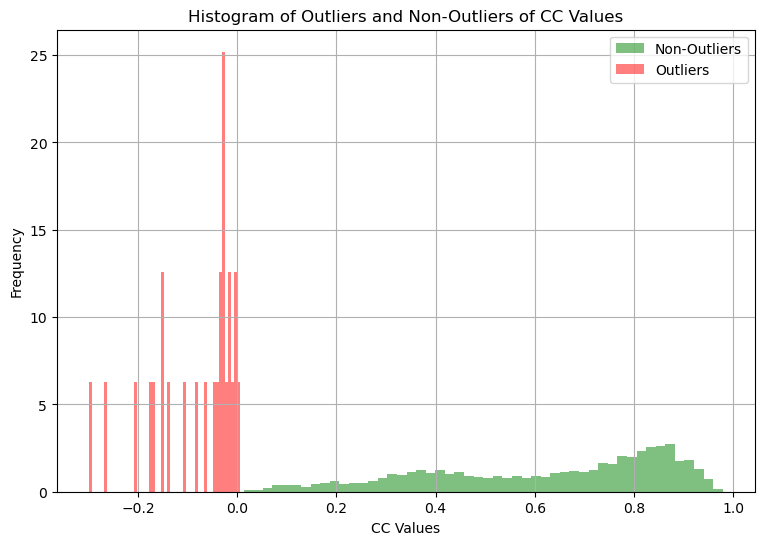

In [30]:
n_bins = 50
plt.figure(figsize=(9, 6))
plt.hist(non_outliers, bins=n_bins, density = True, alpha=0.5, color = 'g', label='Non-Outliers')
plt.hist(outliers, bins=n_bins,  density = True, alpha=0.5, color='r', label='Outliers')

plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of Outliers and Non-Outliers of CC Values')
plt.legend()
plt.grid(True)
plt.show()

See How Test & Training Sets Differ

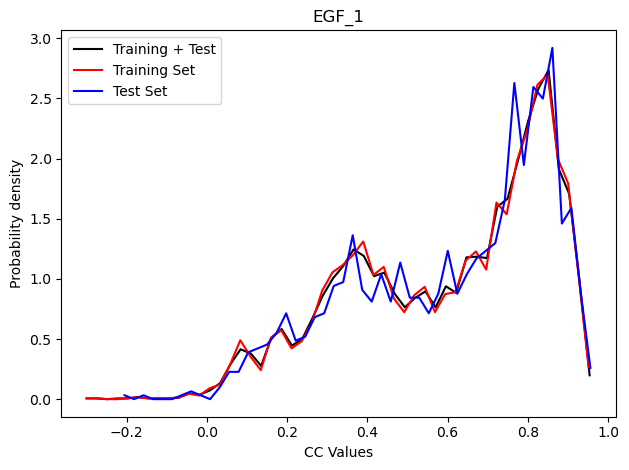

In [30]:
counts, bins = np.histogram(y, n_bins, density=True)
plt.plot(bins[:-1], counts, 'k', label = 'Training + Test')
counts, bins = np.histogram(y_train, n_bins, density=True)
plt.plot(bins[:-1], counts, 'r', label = 'Training Set')
counts, bins = np.histogram(y_test, n_bins, density=True)
plt.plot(bins[:-1], counts, 'b', label = 'Test Set')
plt.xlabel('CC Values')
plt.ylabel('Probability density')
plt.title('EGF_1')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

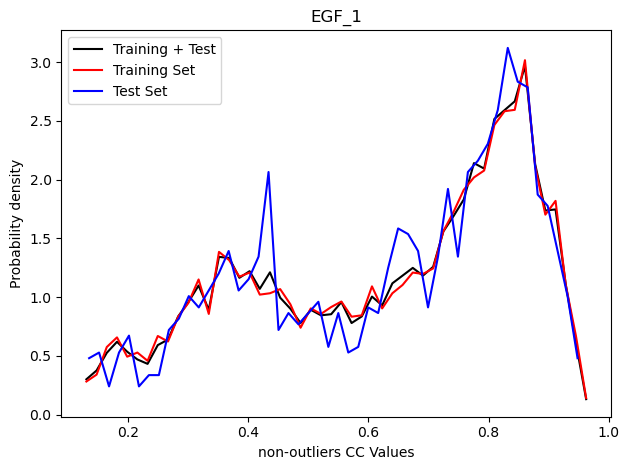

In [31]:
counts, bins = np.histogram(cc_vals_non_outliers, n_bins, density=True)
plt.plot(bins[:-1], counts, 'k', label = 'Training + Test')
counts, bins = np.histogram(y_train_no, n_bins, density=True)
plt.plot(bins[:-1], counts, 'r', label = 'Training Set')
counts, bins = np.histogram(y_test_no, n_bins, density=True)
plt.plot(bins[:-1], counts, 'b', label = 'Test Set')
plt.xlabel('non-outliers CC Values')
plt.ylabel('Probability density')
plt.title('EGF_1')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [33]:
model_lasso = LassoCV(alphas=None, cv=10, max_iter=10000, n_jobs=-1) # Least Absolute Shrinkage and Selection Operator
model_lasso.fit(X_train, y_train)

print(f"Best alpha: {model_lasso.alpha_}") # Best alpha
y_pred_lasso = model_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Squared Error: {mse_lasso}")
#print(f"Coefficients: {model_lasso.coef_}")

Best alpha: 0.0013818764994801952
Mean Squared Error: 0.05031970770707699


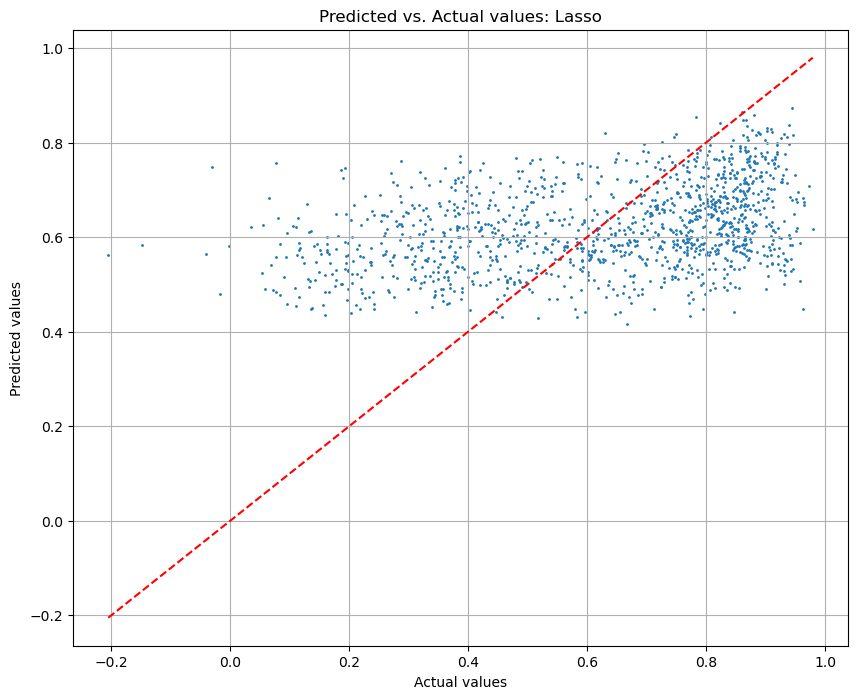

In [34]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_pred_lasso, s=1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values: Lasso')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

In [35]:
model_lasso = LassoCV(alphas=None, cv=10, max_iter=10000, n_jobs=-1) # Least Absolute Shrinkage and Selection Operator
model_lasso.fit(X_train_no, y_train_no)

print(f"Best alpha: {model_lasso.alpha_}") # Best alpha
y_pred_lasso_no = model_lasso.predict(X_test_no)
mse_lasso_no = mean_squared_error(y_test_no, y_pred_lasso_no)
print(f"Mean Squared Error: {mse_lasso_no}")

Best alpha: 0.001536545223963504
Mean Squared Error: 0.04222363660125557


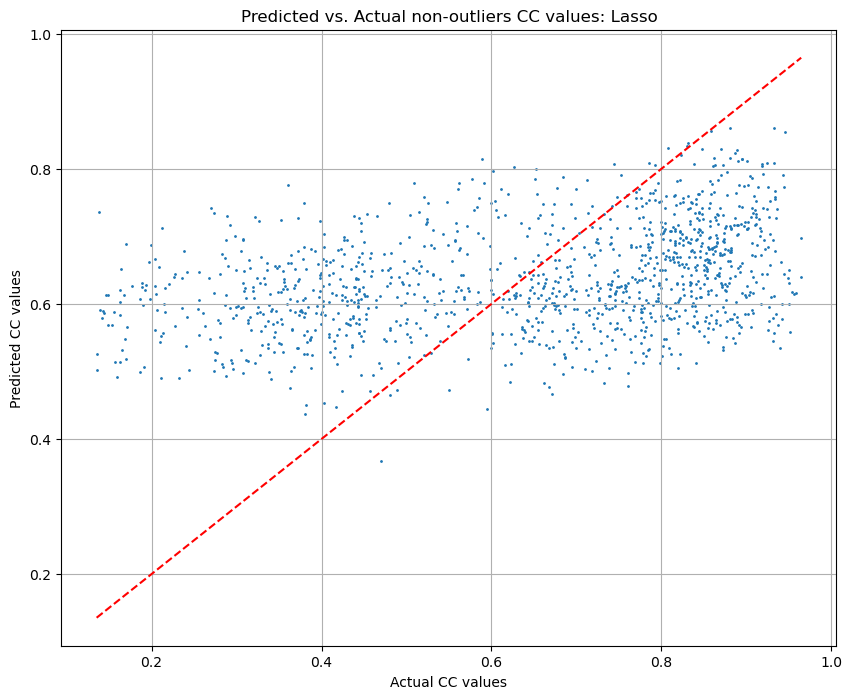

In [36]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test_no, y_pred_lasso_no, s=1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Lasso')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_no.min(), y_pred_lasso_no.min())
max_val = max(y_test_no.max(), y_pred_lasso_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

In [31]:
n_folds_cv = 10
#cv = StratifiedKFold(n_fold_cv) # Stratified K-fold Cross Validations 
cv_kFold = KFold(n_splits = n_folds_cv, # n_splits fold cross-validations 
                 shuffle = True,
                 random_state = 42) # Simple K-fold Cross Validations

Recursive Feature Elimination with Cross Validations 

In [38]:
min_features_to_select =  1
model_linReg = LinearRegression(fit_intercept = True) # Linear regression model
rfecv_linReg = RFECV(estimator = model_linReg,
                     step = 1, 
                     cv = cv_kFold, 
                     #scoring = "accuracy", 
                     scoring = 'neg_mean_squared_error',  # Using negative MSE as the scoring method
                     min_features_to_select = min_features_to_select, 
                     n_jobs = -1)

In [39]:
rfecv_linReg.fit(X_train, y_train) # Recursive Feature Elimination Cross-Validation
y_pred_linReg = rfecv_linReg.predict(X_test) # Predicting the test set results

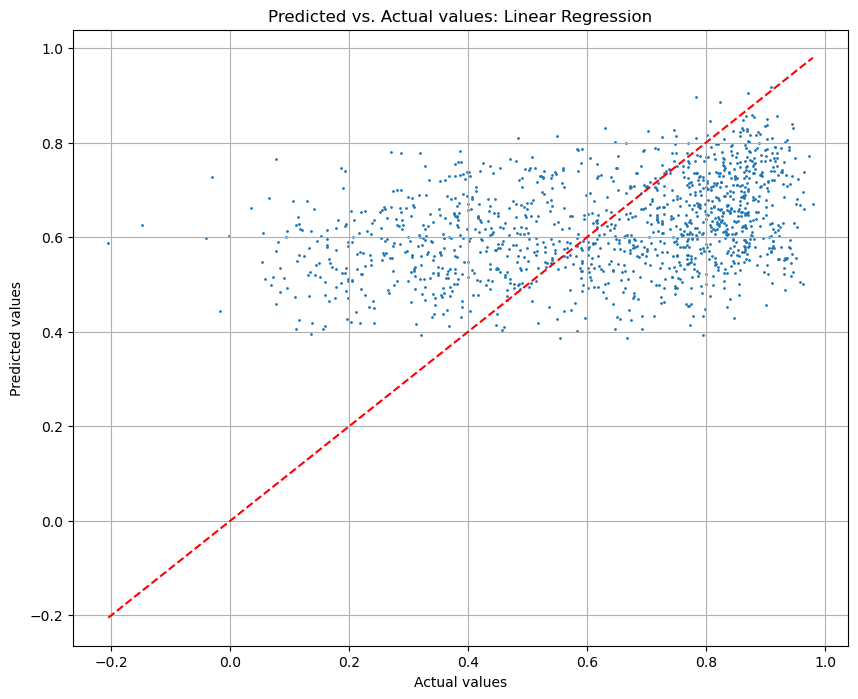

In [40]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test, y_pred_linReg, s = 1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. Actual values: Linear Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test.min(), y_pred_linReg.min())
max_val = max(y_test.max(), y_pred_linReg.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

In [41]:
mse = mean_squared_error(y_test, y_pred_linReg)
r2 = r2_score(y_test, y_pred_linReg)
print(f"Mean Squared Error: {mse} R^2 Score: {r2}")

Mean Squared Error: 0.051060112865793275 R^2 Score: 0.12109430812475197


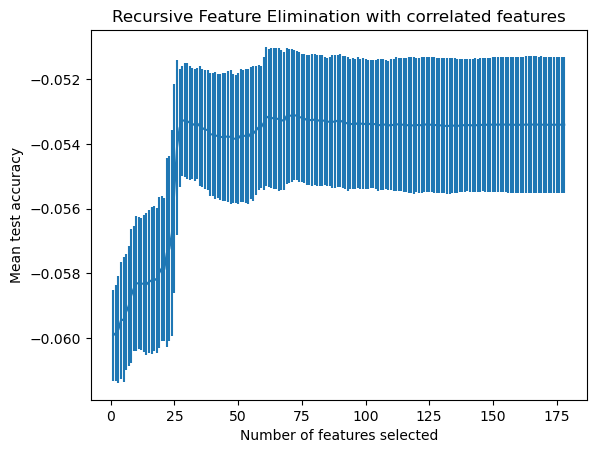

In [42]:
min_features_to_select = 1
n_scores = len(rfecv_linReg.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_linReg.cv_results_["mean_test_score"], 
             yerr=rfecv_linReg.cv_results_["std_test_score"])
plt.title("Recursive Feature Elimination with correlated features")
plt.show()

In [43]:
print(f"Number of Predictive Features: {rfecv_linReg.n_features_}")
selected_features = np.where(rfecv_linReg.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

Number of Predictive Features: 72
Most Predictive Feature Indices:[  0   1   2   3   6   9  11  13  20  31  33  38  45  46  47  54  57  62
  65  66  69  70  73  74  75  76  78  80  81  83  85  86  93  94  95  96
  99 100 107 110 111 119 126 133 135 141 143 144 145 147 149 151 152 153
 154 155 156 157 158 161 163 164 165 166 167 170 171 173 174 175 176 177]


In [44]:
rfecv_linReg.fit(X_train_no, y_train_no) # Recursive Feature Elimination Cross-Validation
y_pred_linReg_no = rfecv_linReg.predict(X_test_no) # Predicting the test set results

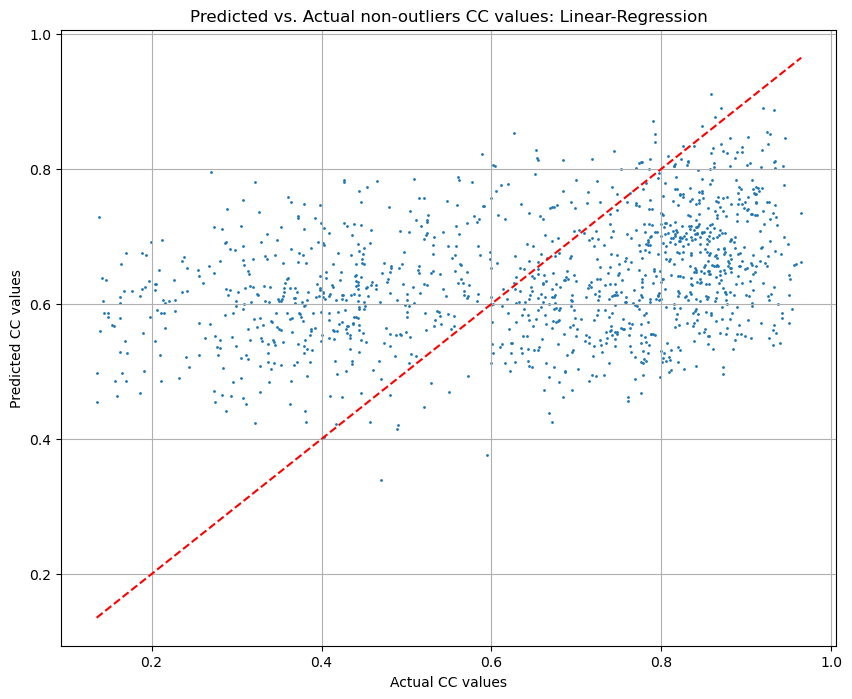

In [45]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test_no, y_pred_linReg_no, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Linear-Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_no.min(), y_pred_lasso_no.min())
max_val = max(y_test_no.max(), y_pred_lasso_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

Random Forest Regression model

In [32]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(Xpca,
                                                                y, 
                                                                test_size = 0.2, 
                                                                random_state = 42)

In [33]:
model_RF_Reg = RandomForestRegressor(n_estimators = 40, # Number of Trees 
                                     random_state = 42) 

In [34]:
rfecv_RF = RFECV(estimator = model_RF_Reg,
                 step = 1, 
                 cv = cv_kFold, 
                 #scoring = "accuracy", 
                 scoring = 'neg_mean_squared_error',  # Using negative MSE as the scoring method
                 min_features_to_select = 1,
                 verbose = 1,
                 n_jobs = -1)

In [ ]:
rfecv_RF.fit(X_train_rf, y_train_rf) # Recursive Feature Elimination Cross-Validation

In [128]:
y_pred_RF = rfecv_RF.predict(X_test_rf) # Predicting the test set results

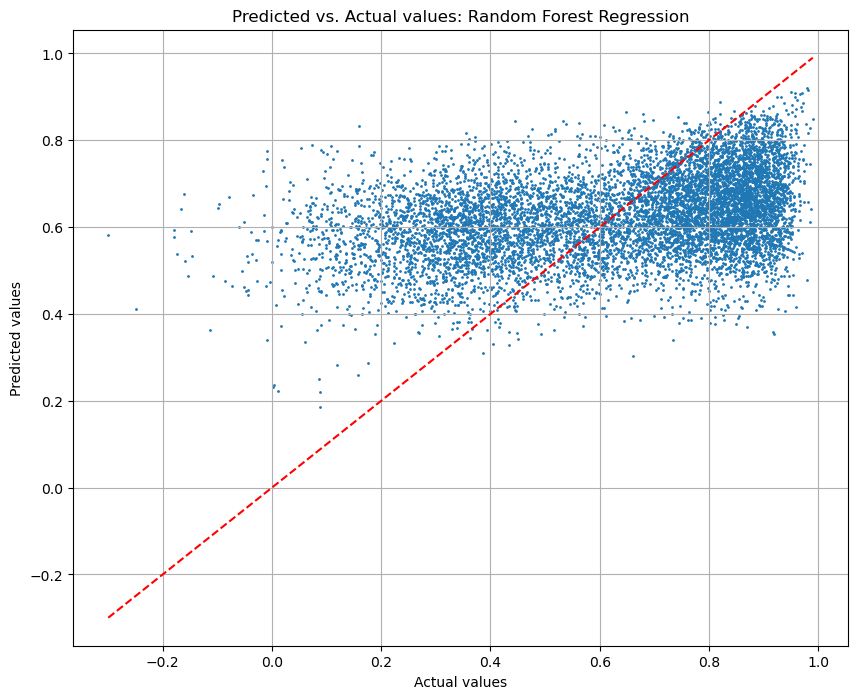

In [132]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test_rf, y_pred_RF, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual CC values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_rf.min(), y_pred_RF.min())
max_val = max(y_test_rf.max(), y_pred_RF.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

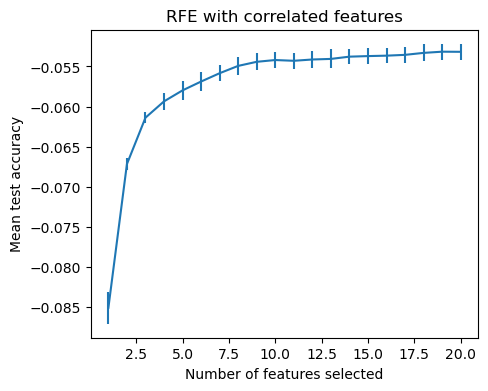

In [130]:
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (5, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features")
plt.show()

In [131]:
print(f"Number of Predictive Features: {rfecv_RF.n_features_}")
selected_features = np.where(rfecv_RF.support_ == True)[0] # Identifying the selected features
print(f"Most Predictive Feature Indices:{selected_features}")

Number of Predictive Features: 19
Most Predictive Feature Indices:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19]
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator w

In [47]:
pca.fit(X_non_outliers) 
Xpca_no = pca.transform(X_non_outliers)

X_train_rf_no, X_test_rf_no, y_train_rf_no, y_test_rf_no = train_test_split(Xpca_no,
                                                                            cc_vals_non_outliers, 
                                                                            test_size = 0.2, 
                                                                            random_state = 42)

In [51]:
rfecv_RF.fit(X_train_rf_no, y_train_rf_no) # Recursive Feature Elimination Cross-Validation

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFECV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
      estimator=RandomForestRegressor(n_estimators=40, random_state=42),
      n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

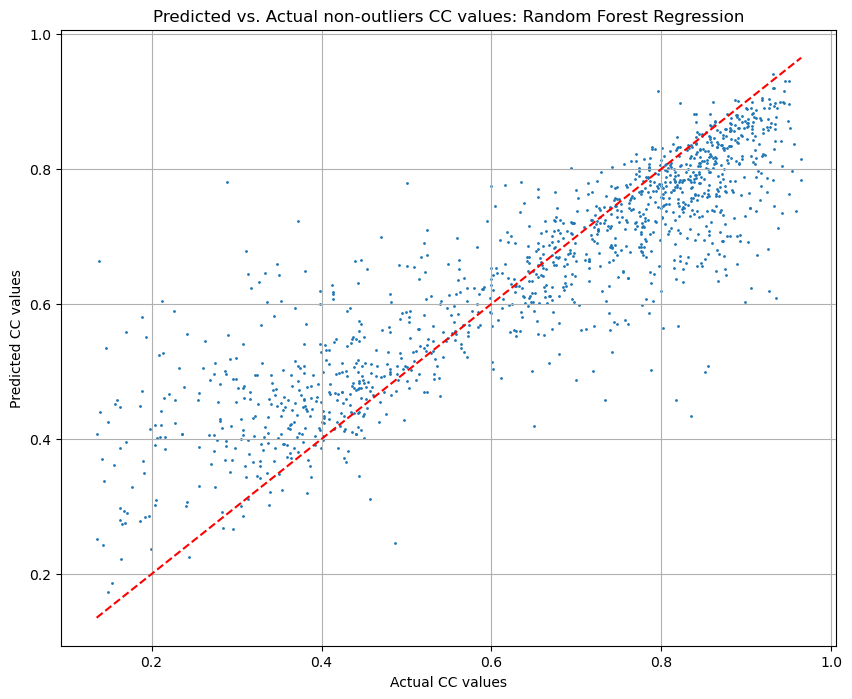

In [52]:
y_pred_RF_no = rfecv_RF.predict(X_test_rf_no) # Predicting the test set results

plt.figure(figsize=(10, 8))
plt.scatter(y_test_rf_no, y_pred_RF_no, s = 1)
plt.xlabel('Actual CC values')
plt.ylabel('Predicted CC values')
plt.title('Predicted vs. Actual non-outliers CC values: Random Forest Regression')
plt.grid(True)

# Calculate the range to include both actual and predicted values
min_val = min(y_test_rf_no.min(), y_pred_RF_no.min())
max_val = max(y_test_rf_no.max(), y_pred_RF_no.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--')  # Perfect prediction
plt.show()

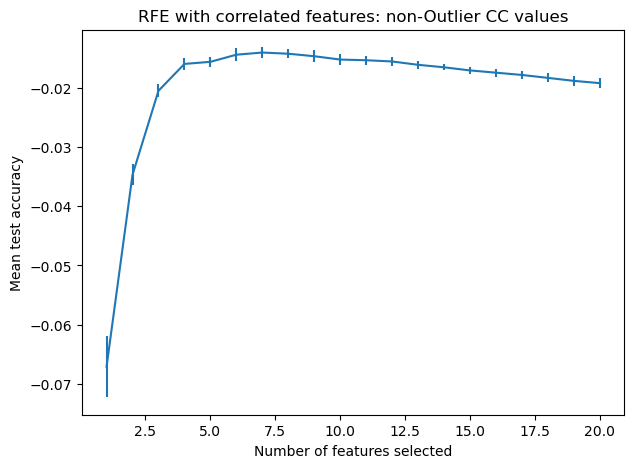

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


In [53]:
n_scores = len(rfecv_RF.cv_results_["mean_test_score"])
plt.figure(figsize = (7, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(range(min_features_to_select, n_scores + min_features_to_select), rfecv_RF.cv_results_["mean_test_score"], 
             yerr=rfecv_RF.cv_results_["std_test_score"])
plt.title("RFE with correlated features: non-Outlier CC values")
plt.show()